# Portfolio Optimization and Analysis

#### Imports

In [231]:
import pandas as pd
import quandl
import matplotlib.pyplot as plt
%matplotlib inline

#### Get Quandl private key

In [232]:
quandl_private_key = open('private/quandlKey.txt', 'r').read()

#### Period of the analysis

In [233]:
start_date = pd.to_datetime('2017-02-01')
end_date = pd.to_datetime('2018-10-22')

#### Create the portfolio

In [236]:
portfolio_list = ['INDUSINDBK', 'BRITANNIA', 'ASIANPAINT', 'JSWSTEEL']

In [237]:
portfolio_close_price = pd.DataFrame()

for stock in portfolio_list:
    portfolio_close_price[stock] = quandl.get("NSE/{}.5".format(stock), authtoken=quandl_private_key, start_date=start_date, end_date=end_date)['Close']

In [ ]:
portfolio_close_price.info()

In [ ]:
portfolio_close_price.describe()

In [ ]:
portfolio_close_price.head()

In [ ]:
portfolio_close_price.to_csv('portfolio_close.csv')

#### Normalize Prices
This is the same as cumulative daily returns

In [ ]:
portfolio_close_price_normalized = portfolio_close_price.copy()

for stock in portfolio_close_price.columns:
    portfolio_close_price_normalized[stock] = portfolio_close_price[stock]/portfolio_close_price.iloc[0][stock]

In [ ]:
portfolio_close_price_normalized.head()

In [ ]:
portfolio_close_price_normalized.tail()

#### Allocations

In [ ]:
#30% in Stock 1
#20% in Stock 2
#40% in Stock 3
#10% in Stock 4
allocation = [0.3,0.2,0.4,0.1]

In [ ]:
portfolio_size = 1000000

In [ ]:
portfolio_normalized_allocation = portfolio_close_price_normalized.copy()

allocation_index = 0

for stock in portfolio_close_price_normalized.columns:
    portfolio_normalized_allocation[stock] = portfolio_close_price_normalized[stock].apply(lambda normalized_return : normalized_return * allocation[allocation_index] * portfolio_size)
    allocation_index += 1

In [ ]:
portfolio_normalized_allocation.head()

In [ ]:
portfolio_normalized_allocation['Total Position'] = portfolio_normalized_allocation.sum(axis=1)

In [ ]:
portfolio_normalized_allocation.tail()

In [ ]:
portfolio_normalized_allocation['Total Position'].plot(figsize=(16,9))
plt.title('Total Portfolio Value');

In [ ]:
portfolio_normalized_allocation.drop('Total Position',axis=1).plot(kind='line', figsize=(16,9));

## Portfolio Statistics

#### Daily Returns

In [ ]:
portfolio_normalized_allocation['Daily Return'] = portfolio_normalized_allocation['Total Position'].pct_change(1)

In [ ]:
portfolio_normalized_allocation.head()

In [ ]:
#Overall Cumulative Return (not daily)
cumulative_return = 100 * (portfolio_normalized_allocation['Total Position'][-1]/portfolio_normalized_allocation['Total Position'][0] - 1 )
print('Our return was {}%!'.format(cumulative_return))

#### Avg Daily Return

In [ ]:
portfolio_normalized_allocation['Daily Return'].mean()

#### Standard Deviation of Daily Return

In [ ]:
portfolio_normalized_allocation['Daily Return'].std()

In [ ]:
portfolio_normalized_allocation['Daily Return'].plot(kind='kde', figsize=(16,9));

In [ ]:
portfolio_normalized_allocation['Daily Return'].plot(kind='hist', bins=100, figsize=(16,9));

# Sharpe Ratio
The Sharpe Ratio is a measure for calculating risk-adjusted return, and this ratio has become the industry standard for such calculations.

Sharpe ratio = (Mean portfolio return − Risk-free rate)/Standard deviation of portfolio return

The original Sharpe Ratio

Annualized Sharpe Ratio = K-value * SR

K-values for various sampling rates:

Daily = sqrt(252)
Weekly = sqrt(52)
Monthly = sqrt(12)

In [ ]:
daily_rate = ((1.0 + 7)**(1/252))-1
daily_rate

In [ ]:
sharpe_ratio = (portfolio_normalized_allocation['Daily Return'].mean() - daily_rate) / portfolio_normalized_allocation['Daily Return'].std()

In [ ]:
sharpe_ratio

In [ ]:
# https://www.investopedia.com/articles/07/sharpe_ratio.asp
annualized_sharpe_ratio = (252**0.5)*sharpe_ratio
annualized_sharpe_ratio

In [ ]:
fig, ax = plt.subplots(figsize = (16,9))

for stock in portfolio_close_price.columns:
    portfolio_close_price[stock].pct_change(1).plot('kde')
    ax.legend()

# Hedging

In [ ]:
asset_returns = pd.DataFrame(portfolio_normalized_allocation['Daily Return'].iloc[1:])

In [ ]:
asset_returns.columns = ['Asset Returns']

In [241]:
benchmark_returns = quandl.get("NSE/{}.4".format('NIFTY_50'), authtoken=quandl_private_key, start_date=start_date, end_date=end_date)['Close']
benchmark_returns = pd.DataFrame(benchmark_returns.pct_change()[1:])

In [242]:
benchmark_returns.columns = ['Benchmark Returns']

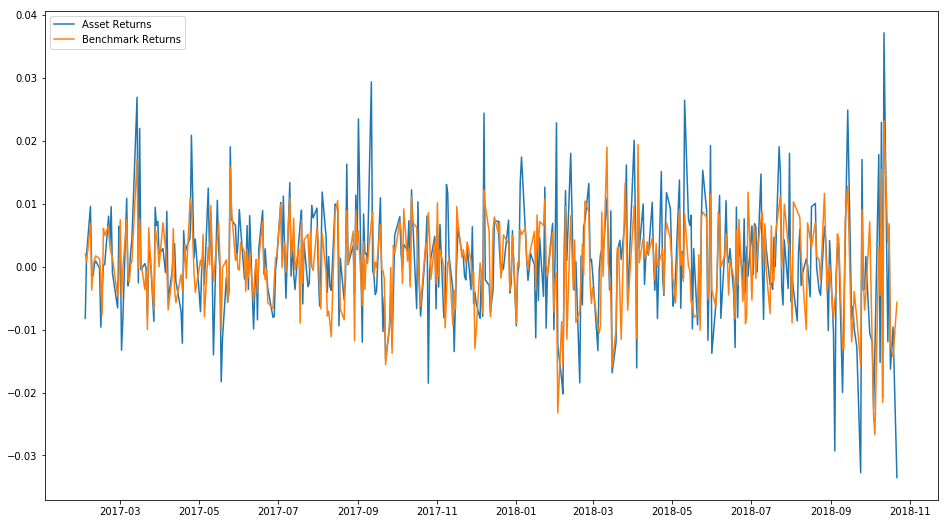

In [243]:
fig, ax = plt.subplots(figsize = (16,9))
ax.plot(asset_returns['Asset Returns'], label = 'Asset Returns')
ax.plot(benchmark_returns['Benchmark Returns'], label = 'Benchmark Returns')
ax.legend()

# Regression for Alpha and Beta Values

Text(0, 0.5, 'AAPL Ret')

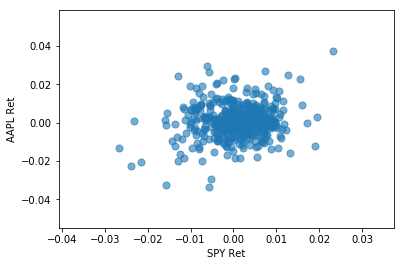

In [248]:
plt.scatter(benchmark_returns['Benchmark Returns'][-420:],asset_returns['Asset Returns'][-420:],alpha=0.6,s=50)
plt.xlabel('SPY Ret')
plt.ylabel('AAPL Ret')